In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#basic imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
mpl.rcParams['figure.figsize'] = 12,8

# Modelling imports
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
# from xgboost import XGBClassifier

#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

-------------------------
/kaggle/input/soccer/database.sqlite


In [2]:
import sqlite3
conn = sqlite3.connect("/kaggle/input/soccer/database.sqlite")

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
player_attributes = pd.read_sql("SELECT * FROM Player_Attributes", conn)
player_attributes.sample(10)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
67450,67451,209236,267863,2013-03-22 00:00:00,72.0,81.0,right,medium,medium,62.0,...,71.0,55.0,72.0,70.0,71.0,9.0,7.0,12.0,12.0,10.0
44359,44360,112556,37416,2009-08-30 00:00:00,69.0,73.0,right,medium,medium,56.0,...,73.0,71.0,65.0,64.0,59.0,14.0,22.0,68.0,22.0,22.0
143130,143131,193311,134217,2015-02-06 00:00:00,73.0,75.0,right,medium,medium,61.0,...,68.0,49.0,71.0,75.0,72.0,8.0,11.0,6.0,9.0,15.0
133141,133142,165501,38385,2010-02-22 00:00:00,77.0,79.0,right,medium,medium,57.0,...,62.0,69.0,81.0,79.0,83.0,14.0,21.0,67.0,21.0,21.0
171088,171089,45721,36007,2015-02-20 00:00:00,69.0,69.0,right,medium,high,64.0,...,59.0,76.0,68.0,71.0,67.0,8.0,8.0,11.0,12.0,9.0
92212,92213,189462,113465,2016-05-05 00:00:00,72.0,76.0,right,medium,low,64.0,...,66.0,68.0,17.0,26.0,25.0,11.0,10.0,9.0,11.0,9.0
147236,147237,2264,32764,2012-02-22 00:00:00,72.0,72.0,right,high,medium,61.0,...,74.0,62.0,12.0,22.0,18.0,14.0,15.0,9.0,11.0,5.0
32503,32504,195541,183515,2010-02-22 00:00:00,65.0,78.0,right,None,_0,64.0,...,57.0,66.0,72.0,73.0,62.0,3.0,23.0,60.0,23.0,23.0
11064,11065,178108,42352,2012-08-31 00:00:00,67.0,71.0,right,medium,medium,58.0,...,65.0,49.0,59.0,61.0,56.0,7.0,15.0,5.0,8.0,9.0
42729,42730,167497,39940,2013-07-05 00:00:00,68.0,71.0,right,medium,medium,39.0,...,56.0,68.0,37.0,34.0,30.0,13.0,13.0,8.0,12.0,12.0


In [4]:
player_attributes.to_csv('player_attr.csv')

# Importing the CSV Data as Pandas DataFrame

In [5]:
df = pd.read_csv('player_attr.csv')
df.sample(10)

,Unnamed: 0,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
139432,139432,139433,183601,93039,2013-03-22 00:00:00,56.0,59.0,right,medium,medium,...,29.0,43.0,53.0,61.0,55.0,15.0,15.0,5.0,7.0,5.0
95827,95827,95828,175314,28109,2014-10-02 00:00:00,69.0,73.0,right,medium,medium,...,74.0,47.0,51.0,58.0,49.0,6.0,10.0,5.0,7.0,7.0
114516,114516,114517,216289,351898,2014-09-18 00:00:00,63.0,70.0,right,medium,medium,...,65.0,58.0,58.0,56.0,55.0,9.0,11.0,12.0,10.0,9.0
56361,56361,56362,208574,281012,2013-09-20 00:00:00,68.0,77.0,left,medium,medium,...,67.0,66.0,34.0,43.0,42.0,12.0,13.0,11.0,11.0,12.0
132856,132856,132857,150668,33117,2008-02-22 00:00:00,70.0,70.0,right,medium,medium,...,69.0,65.0,51.0,59.0,62.0,6.0,25.0,71.0,25.0,25.0
29444,29444,29445,135456,33956,2015-10-23 00:00:00,63.0,63.0,right,medium,low,...,45.0,62.0,12.0,10.0,13.0,13.0,9.0,12.0,8.0,14.0
2006,2006,2007,184433,12245,2013-12-06 00:00:00,70.0,70.0,left,medium,medium,...,41.0,55.0,25.0,25.0,25.0,8.0,15.0,7.0,14.0,14.0
13557,13557,13558,186578,103419,2014-01-24 00:00:00,68.0,73.0,right,high,medium,...,69.0,62.0,55.0,63.0,59.0,7.0,5.0,6.0,9.0,5.0
51627,51627,51628,175313,28971,2013-09-20 00:00:00,67.0,75.0,right,medium,medium,...,67.0,66.0,25.0,32.0,43.0,8.0,7.0,9.0,6.0,14.0
114053,114053,114054,177896,36379,2015-11-19 00:00:00,71.0,73.0,left,medium,medium,...,74.0,55.0,39.0,56.0,35.0,12.0,8.0,8.0,12.0,6.0


In [6]:
df.shape

(183978, 43)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           183978 non-null  int64  
 1   id                   183978 non-null  int64  
 2   player_fifa_api_id   183978 non-null  int64  
 3   player_api_id        183978 non-null  int64  
 4   date                 183978 non-null  object 
 5   overall_rating       183142 non-null  float64
 6   potential            183142 non-null  float64
 7   preferred_foot       183142 non-null  object 
 8   attacking_work_rate  177109 non-null  object 
 9   defensive_work_rate  183142 non-null  object 
 10  crossing             183142 non-null  float64
 11  finishing            183142 non-null  float64
 12  heading_accuracy     183142 non-null  float64
 13  short_passing        183142 non-null  float64
 14  volleys              181265 non-null  float64
 15  dribbling        

In [8]:
df.isnull().sum()

Unnamed: 0                0
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    6869
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking             

In [9]:
df.duplicated().sum()

0

In [10]:
df.nunique()

Unnamed: 0             183978
id                     183978
player_fifa_api_id      11062
player_api_id           11060
date                      197
overall_rating             61
potential                  56
preferred_foot              2
attacking_work_rate         7
defensive_work_rate        19
crossing                   95
finishing                  97
heading_accuracy           96
short_passing              95
volleys                    93
dribbling                  97
curve                      92
free_kick_accuracy         97
long_passing               95
ball_control               93
acceleration               86
sprint_speed               85
agility                    81
reactions                  78
balance                    81
shot_power                 96
jumping                    79
stamina                    84
strength                   82
long_shots                 96
aggression                 91
interceptions              96
positioning                95
vision    

In [11]:
df.describe()

,Unnamed: 0,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91988.50000,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,0.00000,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45994.25000,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91988.50000,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137982.75000,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183977.00000,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


# Missing/NULL Values Imputation

In [12]:
df.isnull().sum()

Unnamed: 0                0
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    6869
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking             

In [13]:
# Getting percentage of null values by Column in the Dataset
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values( ascending = False, inplace=True) # sorting the dataframe

In [14]:
df['attacking_work_rate'].sample(10)

156027      norm
93472     medium
6760      medium
172563    medium
80877     medium
14113     medium
53504       high
26219     medium
155986    medium
125483       NaN
Name: attacking_work_rate, dtype: object

In [15]:
percent_missing

attacking_work_rate    3.733599
vision                 1.474633
jumping                1.474633
curve                  1.474633
volleys                1.474633
balance                1.474633
agility                1.474633
sliding_tackle         1.474633
standing_tackle        0.454402
marking                0.454402
penalties              0.454402
gk_diving              0.454402
positioning            0.454402
interceptions          0.454402
gk_handling            0.454402
aggression             0.454402
gk_kicking             0.454402
long_shots             0.454402
strength               0.454402
stamina                0.454402
gk_positioning         0.454402
shot_power             0.454402
sprint_speed           0.454402
gk_reflexes            0.454402
reactions              0.454402
heading_accuracy       0.454402
overall_rating         0.454402
potential              0.454402
preferred_foot         0.454402
defensive_work_rate    0.454402
crossing               0.454402
finishin

In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
# Exploring Categorical Variables
print("Categories in 'preferred_foot' variable:     ",end=" " )
print(df['preferred_foot'].unique())

print("Categories in 'attacking_work_rate' variable:  ",end=" ")
print(df['attacking_work_rate'].unique())

print("Categories in'defensive_work_rate' variable:",end=" " )
print(df['defensive_work_rate'].unique())

Categories in 'preferred_foot' variable:      ['right' 'left' nan]
Categories in 'attacking_work_rate' variable:   ['medium' 'high' nan 'low' 'le' 'norm' 'stoc' 'y']
Categories in'defensive_work_rate' variable: ['medium' 'high' 'low' '_0' nan '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4'
 'tocky' '0' '3' '6' '9' 'es']


In [18]:
df_copy = df.copy()
df.drop(['Unnamed: 0','player_fifa_api_id','player_api_id'], inplace=True, axis = 1)
df.head(2)

,id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [19]:
# UPDATED THIS CELL AFTER DELETING 3 Cols
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 37 numerical features : ['id', 'date', 'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

We have 3 categorical features : ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']


In [20]:
df.head(2)

,id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [21]:
df.describe()

,id,date,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,2012-12-07 05:49:56.771353088,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,59.175154,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
min,1.00000,2007-02-22 00:00:00,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,2011-02-22 00:00:00,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,52.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,2013-09-20 00:00:00,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,64.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,2014-12-19 00:00:00,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,72.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,2016-07-07 00:00:00,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000
std,53110.01825,NaN,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,17.744688,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155


# Univariate Analysis

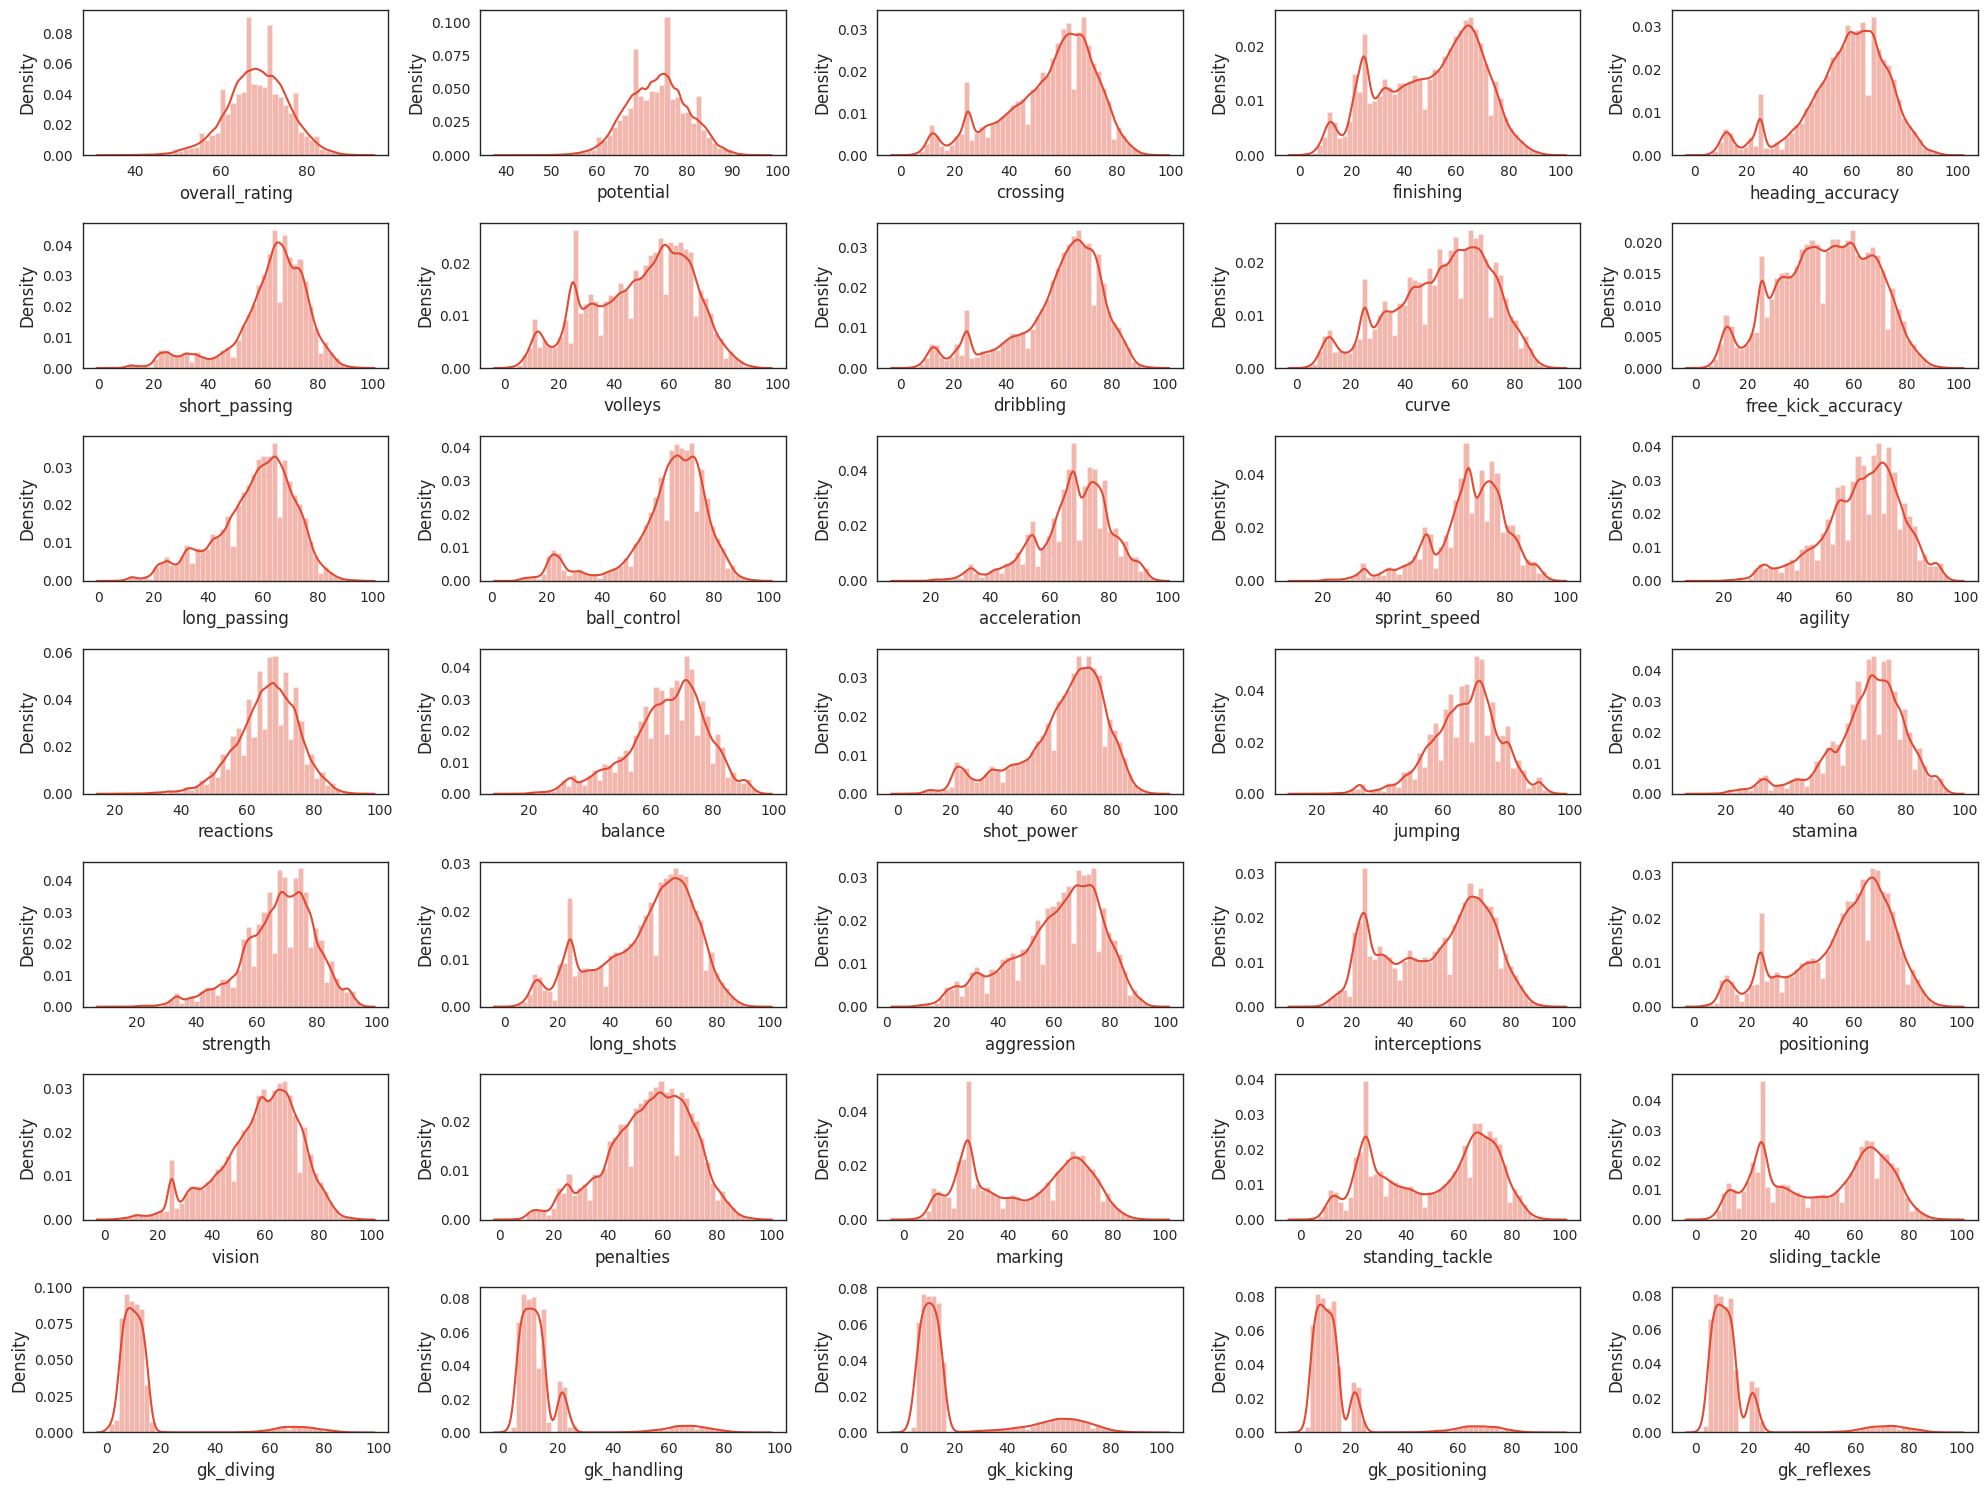

In [22]:
# Loop over all columns
fig, ax = plt.subplots(figsize = (20, 15))
for n, col in enumerate(numeric_features[2:]):
    plt.subplot(7, 5, n+1)
    sns.distplot(df[col])
    # plt.axis('off')
plt.tight_layout()
plt.show()  # Optional: Display the plot before saving (comment out to only save)

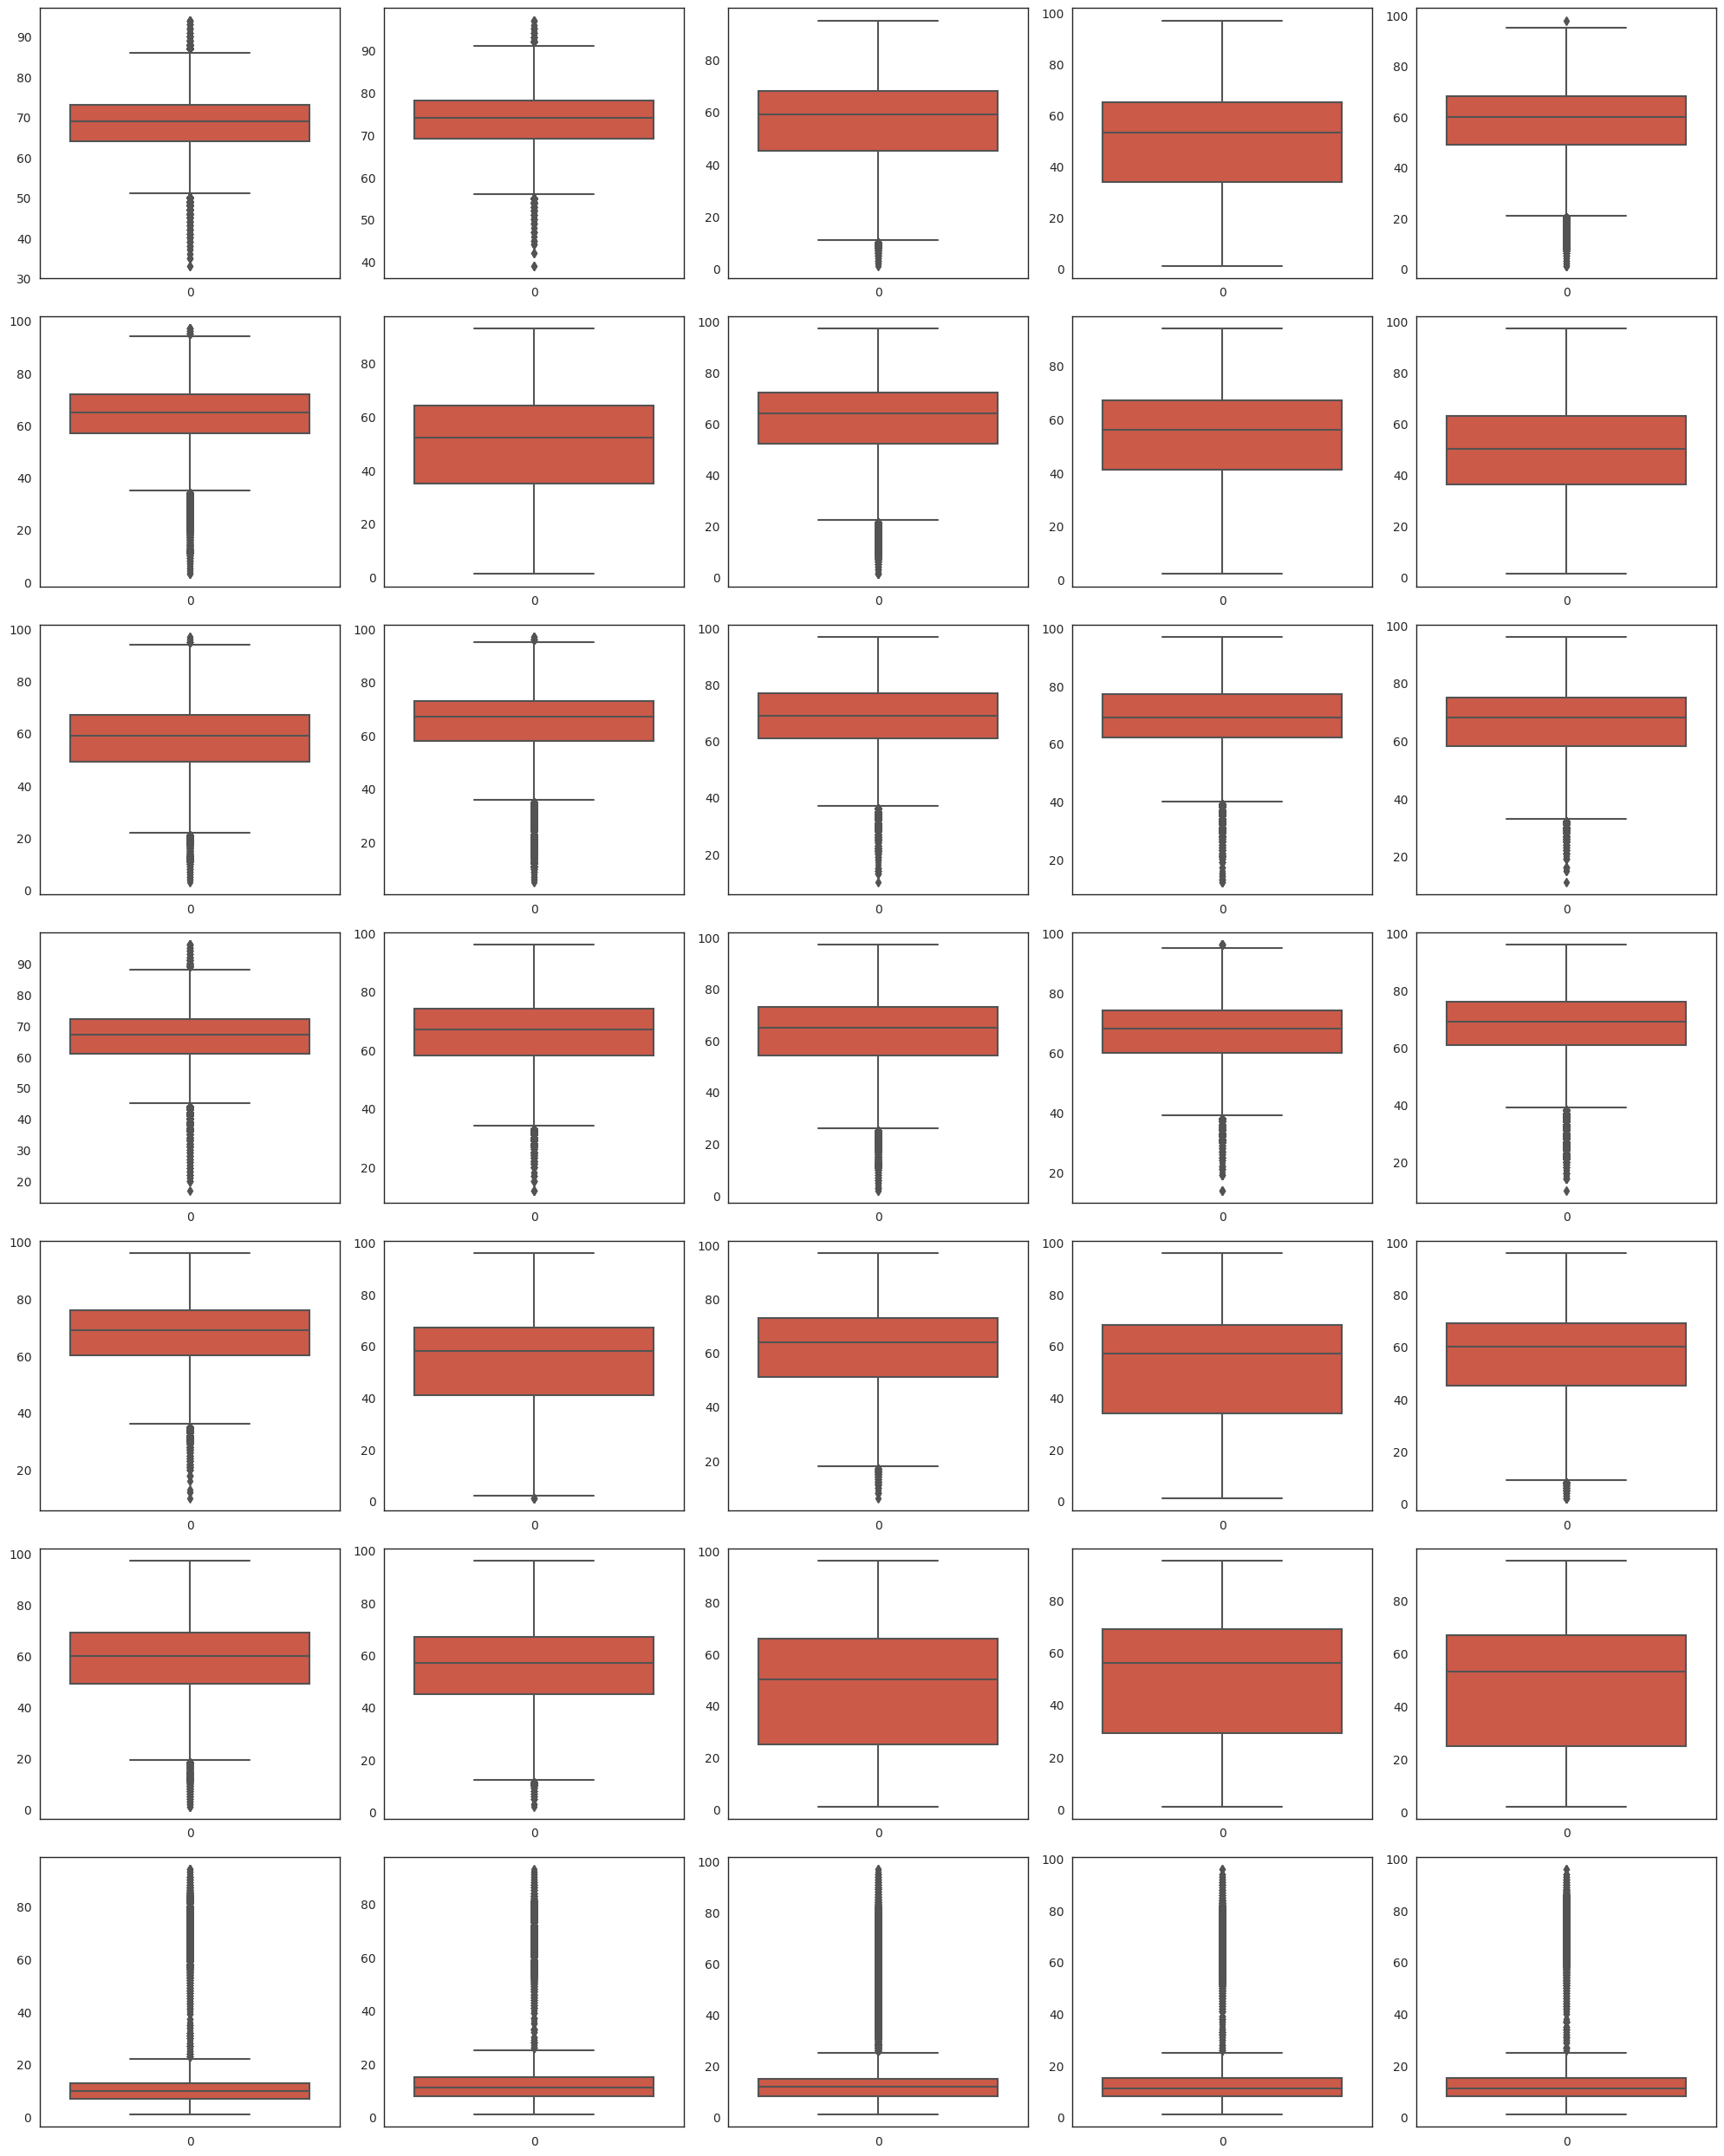

In [23]:
# Loop over all columns
fig, ax = plt.subplots(figsize = (20, 25))
for n, col in enumerate(numeric_features[2:]):
    plt.subplot(7, 5, n+1)
    sns.boxplot(df[col])
    # plt.axis('off')
plt.tight_layout()
plt.show()  # Optional: Display the plot before saving (comment out to only save)